In [13]:
# small network
import torch.nn as nn


class discriminator(nn.Module):
    def __init__(self,input_size):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, int(input_size/4)),
            nn.LeakyReLU(0.2),
            nn.Linear(int(input_size/4), 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)
class generator(nn.Module):
    def __init__(self,output_size):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(4, int(output_size/4)),
            nn.ReLU(),
            nn.Linear(int(output_size/4), output_size),
        )

    def forward(self, input):
        return self.main(input)
    


In [14]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
#from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Discriminator Loss => BCELoss
# abides with comp9417 loss, generator emphasis on samples that fails to fool discriminator
def d_loss_function(inputs, targets):
    return nn.BCELoss()(inputs, targets)

def g_loss_function(inputs):
    targets = torch.ones([inputs.shape[0], 1])
    targets = targets.to(device)
    return nn.BCELoss()(inputs, targets)

In [16]:
from time import time
from LDJoint import MCMC
traindata = np.loadtxt("./data/Sunspot/train.txt")
testdata = np.loadtxt("./data/Sunspot/test.txt")  #
name	= "Sunspot"
trainx = torch.from_numpy(traindata[:,:-1]).type(torch.FloatTensor)
trainy = torch.from_numpy(traindata[:,-1]).type(torch.FloatTensor).reshape((len(traindata),1))
testx  = torch.from_numpy(testdata[:,:-1]).type(torch.FloatTensor)
testy  = torch.from_numpy(testdata[:,-1]).type(torch.FloatTensor).reshape((len(testdata),1))


num_samples = 3000
lr = 0.01
# mcmc
st = time()
mcmc = MCMC(trainx,trainy,testx,testy,True,1,lr,num_samples,networktype='fc',hidden_size=[5])#[4,3])
#print(mcmc.network)
#print(trainx.shape)

#batch_size = 10
#summary(mcmc.network,input_size=(batch_size,4))

#a = 0.1
#b = 0.1
#sigma = 0.025
a = 0
b = 0
sigma = 5
tau_prop_std = 0.01 #0.2
w_prop_std   = 0.02
[theta_all,theta_accepted,fx_train,fx_test,accept_ratio] = mcmc.sample(a,b,sigma,tau_prop_std,w_prop_std)
print(accept_ratio,len(theta_accepted))
print("Time Taken:",time()-st)
theta_accept_burn = theta_accepted[int(theta_accepted.shape[0]/2):,:]
print(theta_accept_burn.shape)

/home/sean/miniconda3/envs/qttrade/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([298])) that is different to the input size (torch.Size([298, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.42 1260
Time Taken: 10.692928552627563
torch.Size([630, 32])


In [19]:
print([x for x in mcmc.network.parameters()])
print(theta_accept_burn)
print(theta_accept_burn.detach())


[Parameter containing:
tensor([[-0.4570,  0.8489,  0.8008,  1.6926],
        [ 0.4653,  0.7685,  0.0866,  0.3168],
        [-0.1006,  0.2119,  0.7183,  0.7893],
        [ 0.4279,  0.3912,  1.5415,  0.2392],
        [ 0.2340, -1.5772,  0.0363, -1.6233]], requires_grad=True), Parameter containing:
tensor([ 0.1033, -0.6138, -1.4660, -0.1747,  1.4566], requires_grad=True), Parameter containing:
tensor([[ 2.1848,  0.0491,  0.8745,  1.7670, -3.9243]], requires_grad=True), Parameter containing:
tensor([-1.4922], requires_grad=True)]
tensor([[-8.3622e-01,  5.0297e-01, -9.6461e-02,  ..., -1.5800e+00,
         -8.9216e-01,  4.0890e-04],
        [-8.2525e-01,  4.6777e-01, -8.1542e-02,  ..., -1.5915e+00,
         -8.9138e-01,  4.0774e-04],
        [-8.1525e-01,  4.5076e-01, -6.4314e-02,  ..., -1.6133e+00,
         -8.6272e-01,  4.0828e-04],
        ...,
        [-4.5457e-01,  8.5287e-01,  7.4665e-01,  ..., -3.9109e+00,
         -1.4882e+00,  4.5623e-06],
        [-4.6408e-01,  8.4352e-01,  7.6653e

In [20]:
from torch.utils.data import DataLoader
traindata = DataLoader(theta_accept_burn.detach(),batch_size=16)

In [46]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Model
G = generator(output_size = theta_accept_burn.shape[1]).to(device)
D = discriminator(input_size=theta_accept_burn.shape[1]).to(device)
print(G)
print(D)

# Settings
epochs = 2000
lr = 0.0002
batch_size = 16
#g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
#d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

g_optimizer = optim.SGD(G.parameters(), lr=lr)
d_optimizer = optim.SGD(D.parameters(), lr=lr)

GPU State: cpu
generator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=32, bias=True)
  )
)
discriminator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [47]:
# Train
for epoch in range(epochs):
    epoch += 1
    for times, data in enumerate(traindata):
        times += 1

        real_inputs = data.to(device)
        #test = 255 * (0.5 * real_inputs[0] + 0.5)
        real_inputs = real_inputs.view(-1, 32)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        latent = torch.randn(real_inputs.shape[0],4)
        latent = latent.to(device)
        fake_inputs = G(latent)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        # Zero the parameter gradients
        d_optimizer.zero_grad()

        # Backward propagation
        d_loss = d_loss_function(outputs, targets)
        d_loss.backward()
        d_optimizer.step()

        # Generator
        latent = torch.randn(real_inputs.shape[0],4)
        latent = latent.to(device)

        fake_inputs = G(latent)
        fake_outputs = D(fake_inputs)

        g_loss = g_loss_function(fake_outputs)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        #if times % 100 == 0 or times == len(traindata):
        #    print('[{}/{}, {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, times, len(traindata), d_loss.item(), g_loss.item()))
        #break
    #imgs_numpy = (fake_inputs.data.cpu().numpy()+1.0)/2.0
    #show_images(imgs_numpy[:16])
    #plt.show()

    if epoch % 50 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')
        print("Epoch",epoch,"discriminator loss: ",d_loss," generator loss: ", g_loss)


print('Training Finished.')
#print('Cost Time: {}s'.format(time.time()-start_time))

Model saved.
Epoch 50 discriminator loss:  tensor(0.7049, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.6803, grad_fn=<BinaryCrossEntropyBackward0>)
Model saved.
Epoch 100 discriminator loss:  tensor(0.6684, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.6819, grad_fn=<BinaryCrossEntropyBackward0>)
Model saved.
Epoch 150 discriminator loss:  tensor(0.6069, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.6871, grad_fn=<BinaryCrossEntropyBackward0>)
Model saved.
Epoch 200 discriminator loss:  tensor(0.5274, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.6769, grad_fn=<BinaryCrossEntropyBackward0>)
Model saved.
Epoch 250 discriminator loss:  tensor(0.4686, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.6899, grad_fn=<BinaryCrossEntropyBackward0>)
Model saved.
Epoch 300 discriminator loss:  tensor(0.4059, grad_fn=<BinaryCrossEntropyBackward0>)  generator loss:  tensor(0.7460, grad_fn=<BinaryCross

torch.Size([31])
tensor(0.0476)
torch.Size([31])
tensor(0.0175)
torch.Size([31])
tensor(0.0262)
torch.Size([31])
tensor(0.0778)
torch.Size([31])
tensor(0.0355)
torch.Size([31])
tensor(0.0164)
torch.Size([31])
tensor(0.1218)
torch.Size([31])
tensor(0.1221)
torch.Size([31])
tensor(0.0221)
torch.Size([31])
tensor(0.0144)


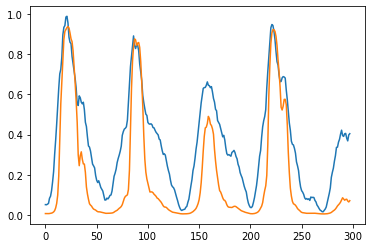

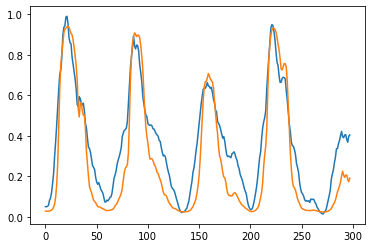

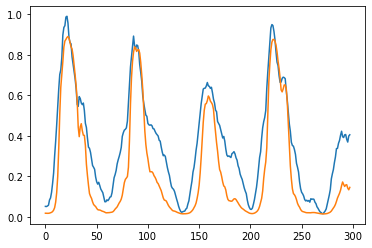

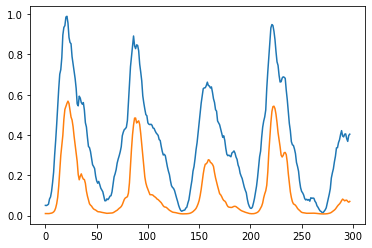

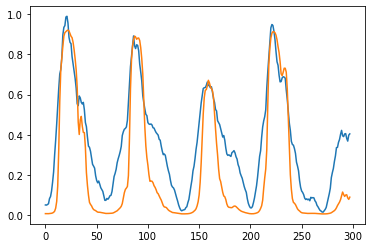

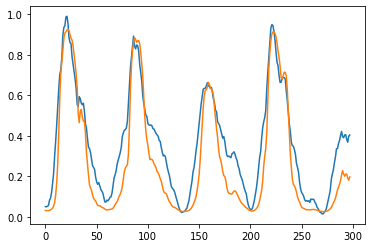

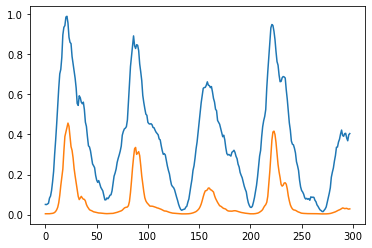

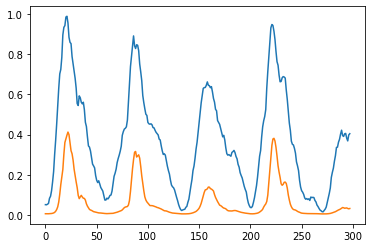

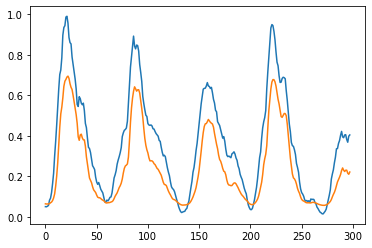

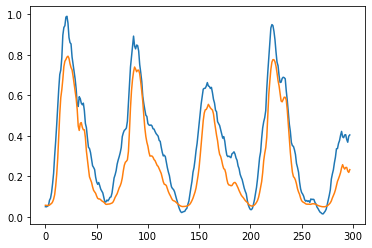

In [48]:
def plotGenWeight(fignum):
    latent = torch.randn(1,4)
    G.eval()
    with torch.no_grad():
        gen_weight = G(latent)
        print(gen_weight.flatten()[:-1].shape)
        mcmc.network.decode(gen_weight.flatten()[:-1])
        out = mcmc.network(mcmc.trainx)
        loss = nn.MSELoss()(mcmc.trainy, out)
        print(loss)
        import matplotlib.pyplot as plt
        plt.figure(fignum)
        plt.plot(mcmc.trainy)
        plt.plot(out)
for i in range(10):
    plotGenWeight(i)